# I. First step : Simple Convolutionnal Neural Network (CNN)

## On MNIST

### Import the library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

### Collecting the data

In [2]:
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transform,
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform
)

In [3]:
print("shape of train data : " , train_data.data.size())
print("shape of test data : " , test_data.data.size())
print("shape of train labels : " , train_data.targets.size())

shape of train data :  torch.Size([60000, 28, 28])
shape of test data :  torch.Size([10000, 28, 28])
shape of train labels :  torch.Size([60000])


### Preprocessing

In [4]:
from torch.utils.data import DataLoader

loaders = {
    'train' : DataLoader(train_data,
                         batch_size=128,
                         shuffle=True,
                         num_workers=1),

    'test'  : DataLoader(test_data,
                         batch_size=128,
                         shuffle=True,
                         num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x104e8dfa0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x13032fc10>}

tensor(5)


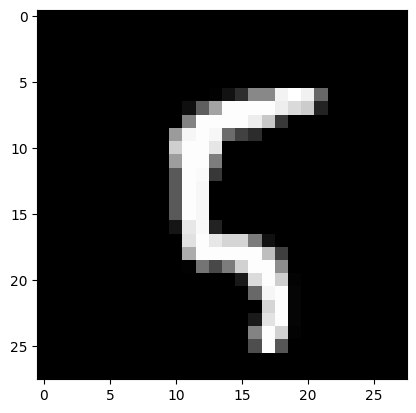

In [5]:
plt.imshow(train_data.data[100],cmap='gray')
print(train_data.targets[100])

### Building the network

In [6]:
import torch.nn as nn
from torch.nn import Sequential,Conv2d,AvgPool2d,Flatten,Linear,Sigmoid

In [7]:
nb_epoch = 20

#Define the model Sequential

model = Sequential(
    Conv2d(in_channels = 1,out_channels = 6,kernel_size = (5,5),padding = 2),
    Sigmoid(),
    AvgPool2d(kernel_size = (2,2),stride = 2),
    Conv2d(in_channels = 6,out_channels = 16,kernel_size = (5,5)),
    Sigmoid(),
    AvgPool2d(kernel_size = (2,2),stride = 2),
    Flatten(),
    Linear(16*5*5,120),
    Sigmoid(),
    Linear(120,84),
    Sigmoid(),
    Linear(84,10)
)

In [8]:
from torchvision import models
from torchsummary import summary
print(model)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [10]:
import torch.optim as optim

#Define Loss function and Optimizer :
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [11]:
num_epochs = 20

#Train the model:

def train(num_epochs, cnn, loaders):
    loss_value = np.zeros((20,2))
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(loaders['train'], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % 100 == 0:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
        loss_value[epoch] = [epoch,loss.item()]
    print('Finished Training')
    return loss_value
loss_value  = train(nb_epoch,model, loaders)

[1,   100] loss: 2.302
[1,   200] loss: 1.841
[1,   300] loss: 0.952
[1,   400] loss: 0.622
[2,   100] loss: 0.411
[2,   200] loss: 0.343
[2,   300] loss: 0.296
[2,   400] loss: 0.264


KeyboardInterrupt: 

In [ ]:
#Test the model:

def test(cnn,loaders):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loaders['test']:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnn(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            print(labels.size(0))
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
test(model,loaders)

In [12]:
#Plot the loss
plt.plot(loss_value[:,0],loss_value[:,1])
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

NameError: name 'loss_value' is not defined

# II. Second step: Simple Convolutionnal Neural Network on more complex data.

### Load the data

In [13]:
from torch.utils.data import TensorDataset

xTrain=np.load('./pathmnist/train_images.npy')
xTest=np.load('./pathmnist/test_images.npy')
yTrain=np.load('./pathmnist/train_labels.npy')
yTest=np.load('./pathmnist/test_labels.npy')

xTrain = torch.Tensor(xTrain)# transform to torch tensor
yTrain = torch.LongTensor(yTrain)
xTest = torch.Tensor(xTest)
yTest = torch.LongTensor(yTest)

#Change the size (:,28,28,3) to (:,3,28,28)
xTrain = xTrain.permute(0, 3, 1, 2)
xTest = xTest.permute(0, 3, 1, 2)

train_dataset = TensorDataset(xTrain,yTrain) # create your datset
test_dataset = TensorDataset(xTest,yTest)

loaders = {
    'train' : DataLoader(train_dataset,
                         batch_size=64,
                         shuffle=100,
                         num_workers=1),

    'test'  : DataLoader(test_dataset,
                         batch_size=64,
                         shuffle=100,
                         num_workers=1),
}
loaders
print(loaders['train'])

### Building the network

In [14]:
from torch import sigmoid,flatten

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels = 3,out_channels = 6,kernel_size = (5,5),padding = 2)
        self.pool = AvgPool2d(kernel_size = (2,2),stride = 2)
        self.conv2 = Conv2d(in_channels = 6,out_channels = 16,kernel_size = (5,5))
        self.fc1 = Linear(16 * 5 * 5, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 9)

    def forward(self, x):
        x = self.pool(sigmoid(self.conv1(x)))
        x = self.pool(sigmoid(self.conv2(x)))
        x = flatten(x,1) # flatten all dimensions except batch
        x = sigmoid(self.fc1(x))
        x = sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

In [15]:
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)


In [16]:
summary(model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 9]             765
Total params: 61,921
Trainable params: 61,921
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [17]:
def train(num_epochs, cnn, loaders):
    loss_value = np.zeros((20,2))
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(loaders['train'], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = criterion(outputs, labels[:,0]) #To have label in good size
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % 100 == 0:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
        loss_value[epoch] = [epoch,loss.item()]
    print('Finished Training')
    return loss_value

loss_value  = train(nb_epoch,model,loaders)

[1,   100] loss: 2.286
[1,   200] loss: 2.288
[1,   300] loss: 2.287
[1,   400] loss: 2.287
[1,   500] loss: 2.283
[1,   600] loss: 2.280
[1,   700] loss: 2.282
[1,   800] loss: 2.285
[1,   900] loss: 2.282
[1,  1000] loss: 2.283


KeyboardInterrupt: 

In [ ]:
def test(cnn,loaders):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loaders['test']:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnn(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            print(labels.size(0))
            print((predicted == labels).sum().item())
            correct += (predicted == labels).sum().item()
    print(correct)
    print(total)
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

test(model,loaders)

In [ ]:
#Plot the loss
plt.plot(loss_value[:,0],loss_value[:,1])
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

# Third step : Transfer learning

## Load the data

In [62]:
import glob
from tqdm import tqdm
from torchvision.models import vgg16
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder

In [63]:
classes = ['mucca', 'elefante', 'gatto', 'cavallo', 'scoiattolo', 'ragno', 'pecora', 'farfalla', 'gallina', 'cane']
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = ImageFolder(root='./animal-10/raw-img/train', transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


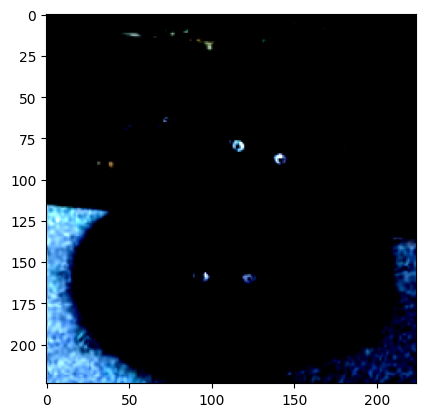

In [64]:
# get a batch of images from the dataloader
images, labels = next(iter(dataloader))
# plot the first image in the batch
plt.imshow(images[0].permute(1, 2, 0))
plt.show()

In [83]:
# Load train data
from torch.utils.data import SubsetRandomSampler

# get the indices of the images in the three classes we want
class_indices = []
for class_label in tqdm(['mucca', 'elefante', 'gatto']):
    indices = [i for i, (image, label) in enumerate(dataset) if label == class_label]
    # shuffle the indices to get a random subset
    indices = torch.randperm(len(indices))[:200]
    class_indices.append(indices)

# concatenate the indices of the selected images
indices = torch.cat(class_indices)

# create a sampler with the selected indices
sampler = SubsetRandomSampler(indices)

# create a dataloader for the subset
train = torch.utils.data.DataLoader(dataset, sampler=sampler, batch_size=32)

100%|██████████| 3/3 [00:15<00:00,  5.21s/it]


In [84]:
#Load test data

dataset = ImageFolder(root='./animal-10/raw-img/test', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

## Define the model

In [89]:
from torch.nn import Softmax,AdaptiveAvgPool2d

vgg_model = models.vgg16(pretrained=True)

# Modify the classifier of the VGG16 model
num_features = vgg_model.classifier[-1].in_features
# Define a custom classifier to be added to the model
classifier = Sequential(
    AdaptiveAvgPool2d((1, 1)),
    Flatten(),
    Linear(512, 1024),
    Sigmoid(),
    Linear(1024, 10),
    Softmax(dim=1)
)

# Replace the VGG16 classifier with the custom classifier
vgg_model.classifier = classifier


/Users/thibaut/Desktop/DeepLearning/Lab4/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/thibaut/Desktop/DeepLearning/Lab4/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [90]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [91]:
summary(vgg_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,